In [1]:
import jax.numpy as jnp
import jax
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def grad_descent(f, grad, x0, num_iter, eps, alpha_=None):
    x = x0.copy()
    conv = [x.copy()]
    for i in range(num_iter):
        h = -grad(x)
        if jnp.linalg.norm(h) < eps:
            break
        if alpha_ is None:
            alpha = h @ h / (h @ A @ h)
        else:
            alpha = alpha_
        x = x + alpha * h
        conv.append(x.copy())
    return x, conv

def heavy_ball(f, grad, x0, num_iter, eps, alpha, beta):
    x = x0.copy()
    conv = [x.copy()]
    prev_x = None
    for i in range(num_iter):
        h = -grad(x)
        if prev_x is None:
            prev_x = x
            x = x + alpha * h
        else:
            x, prev_x = x + alpha * h + beta * (x - prev_x), x
        conv.append(x.copy())
    return x, conv

In [3]:
def my_f(x, A):
    return 0.5 * x.dot(A.dot(x))

def my_gradf(x, A):
    return A.dot(x)

Text(0, 0.5, 'Number of iterations with $\\varepsilon = 10^{-7}$')

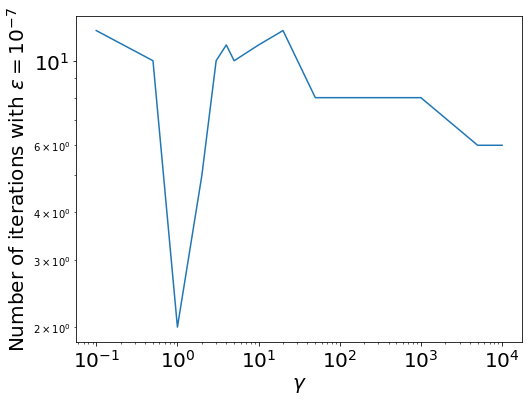

In [4]:
gammas = [0.1, 0.5, 1, 2, 3, 4, 5, 10, 20, 50, 100, 1000, 5000, 10000]
# gammas = [1]
num_iter_converg = []
for g in gammas:
    A = np.array([[1, 0], 
                  [0, g]], dtype=np.float64)
    f = lambda x: my_f(x, A)
    gradf = lambda x: my_gradf(x, A)
    x0 = np.random.rand(A.shape[0])
#     x0 = np.sort(x0)
#     x0 = x0[::-1]
    # x0 = np.array([g, 1], dtype=np.float64)
#     print x0[1] / x0[0]
    _, conv = grad_descent(f, gradf, x0, 1000, 1e-5)
    num_iter_converg.append(len(conv))

plt.figure(figsize=(8, 6))
plt.loglog(gammas, num_iter_converg)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel(r"$\gamma$", fontsize=20)
plt.ylabel(r"Number of iterations with $\varepsilon = 10^{-7}$", fontsize=20)

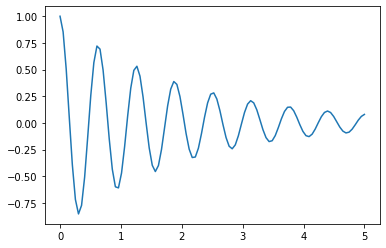

In [5]:
w = np.array([1, -0.5, 10, 0])
def f(x, w):
    return w[0] * jnp.exp(x * w[1]) * jnp.cos(w[2] * x + w[3])

num_points = 100
x_range = np.linspace(0, 5, num=num_points)
plt.plot(x_range, f(x_range, w))

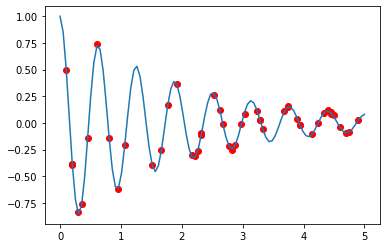

In [6]:
num_samples = 50
x_samples = np.random.choice(x_range, size=num_samples)
y_samples = f(x_samples, w) + 0.01 * np.random.randn(num_samples)
plt.plot(x_range, f(x_range, w))
plt.scatter(x_samples, y_samples, c="red")

In [7]:
objective = lambda w: (y_samples - f(x_samples, w)) @ (y_samples - f(x_samples, w))
grad_obj = jax.jit(jax.grad(objective))

In [8]:
grad_obj(jnp.array(w))

DeviceArray([0.04022051, 0.02423496, 0.03505375, 0.03992179], dtype=float64)

In [9]:
y_samples - f(x_samples, w)

DeviceArray([-0.00637485, -0.00779423, -0.02605408,  0.01475856,
              0.0033826 ,  0.00966052,  0.00439075, -0.00125577,
              0.00323138,  0.01430593, -0.01015696, -0.01700792,
             -0.00212589,  0.0117526 ,  0.01979462, -0.00440389,
             -0.00083214, -0.00250783, -0.00673907, -0.00387795,
             -0.00977698,  0.00345211, -0.00061812,  0.01056757,
              0.00092335,  0.00844207,  0.00587763,  0.00580195,
              0.00173485, -0.00741409, -0.00837438, -0.0078113 ,
              0.0159346 ,  0.00141624, -0.00313398, -0.02355754,
             -0.00864419,  0.01021758,  0.00148043, -0.00087774,
              0.00581338,  0.00174187,  0.01263067,  0.00189065,
              0.01081595,  0.00527825, -0.01290763,  0.00525328,
             -0.0152175 , -0.00519589], dtype=float64)

In [35]:
w0 = w + jnp.array(np.random.randn(4))

In [36]:

alpha = 1e-3
beta = 0.9
w_gd, conv_gd = grad_descent(objective, grad_obj, w0, 400, 1e-3, alpha)
w_hb, conv_hb = heavy_ball(objective, grad_obj, w0, 400, 1e-3, alpha, beta)

In [37]:
w_gd, w_hb

(DeviceArray([ 1.58972773, -1.83191619,  9.6454587 ,  0.08434938], dtype=float64),
 DeviceArray([ 9.93959585e-01, -4.98709226e-01,  9.99945796e+00,
              -3.04209950e-03], dtype=float64))

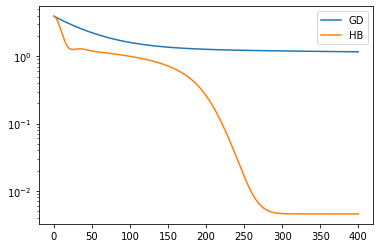

In [38]:
plt.semilogy([objective(x) for x in conv_gd], label="GD")
plt.semilogy([objective(x) for x in conv_hb], label="HB")
plt.legend()

In [39]:
objective(w_gd), objective(w_hb), objective(w)

(DeviceArray(1.16877084, dtype=float64),
 DeviceArray(0.00452621, dtype=float64),
 DeviceArray(0.00470183, dtype=float64))

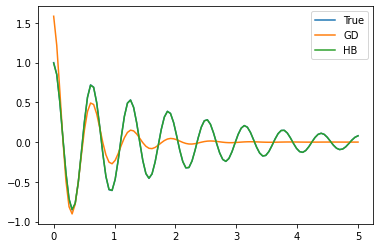

In [40]:
plt.plot(x_range, f(x_range, w), label="True")
plt.plot(x_range, f(x_range, w_gd), label="GD")
plt.plot(x_range, f(x_range, w_hb), label="HB")
plt.legend()